<a href="https://colab.research.google.com/github/Shan-Niit/ML-Titanic/blob/main/House_Prices_Advanced_Regression_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📘 Project Overview — what is this dataset about?

🔍 Objective — predict SalePrice with lowest RMSE

📊 EDA — visualizations

🚀 Models & Evaluation — with comparison table

🧠 Conclusion — what worked best and why

## Import libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [69]:
df = pd.read_csv('/content/train.csv')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [71]:
df.isnull().sum()[df.isnull().sum() > 0]

,0
LotFrontage,259
Alley,1369
MasVnrType,872
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


## Change all the Na for categorical features for "No ..."

In [72]:
df["MiscFeature"] = df["MiscFeature"].fillna("No feature")
df["Fence"] = df["Fence"].fillna("No Fence")
df["PoolQC"] = df["PoolQC"].fillna("No Pool")
df["GarageCond"] = df["GarageCond"].fillna("No Garage")
df["GarageQual"] = df["GarageQual"].fillna("No Garage")
df["GarageFinish"] = df["GarageFinish"].fillna("No Garage")
df["GarageType"] = df["GarageType"].fillna("No Garage")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna("No Basement")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna("No Basement")
df["BsmtCond"] = df["BsmtCond"].fillna("No Basement")
df["BsmtQual"] = df["BsmtQual"].fillna("No Basement")
df["FireplaceQu"] = df["FireplaceQu"].fillna("No Fireplace")
df["MasVnrType"] = df["MasVnrType"].fillna("No Veneer")
df["Alley"] = df["Alley"].fillna("No Alley")
df["BsmtExposure"] = df["BsmtExposure"].fillna("No Basement")


## What are still missing:

In [73]:
df.isnull().sum()[df.isnull().sum() > 0]

,0
LotFrontage,259
MasVnrArea,8
Electrical,1
GarageYrBlt,81


In [74]:
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
df = df.dropna(subset=['Electrical']) # Only one row is missing
df['GarageYrBlt'].fillna(0, inplace=True)
# Create a new column: 1 if garage exists, 0 otherwise
df['HasGarage'] = df['GarageYrBlt'].apply(lambda x: 0 if x == 0 else 1)

In [75]:
df['GarageYrBlt'].fillna(0, inplace=True)
# Create a new column: 1 if garage exists, 0 otherwise
df['HasGarage'] = df['GarageYrBlt'].apply(lambda x: 0 if x == 0 else 1)

#impute missing values using the median per Neighborhood:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)


In [76]:
print(df.isnull().sum()[df.isnull().sum() > 0])
df.duplicated().sum()
# No missing value anymore and no duplicate

Series([], dtype: int64)


np.int64(0)

## Preprocessing pipeline

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Separate columns by data type
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Id')
numerical_cols.remove('SalePrice')

# Define features and target
X_train = df.drop(['SalePrice', 'Id'], axis=1)
y = df['SalePrice']

# Define preprocessing for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())                   # Scale numerical data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False))        # OneHotEncode categorical data (sparse=False to avoid sparse matrix)
])

# Combine both transformers into a single preprocessing step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the transformations to X
X_prepro = preprocessor.fit_transform(X_train)

# Get column names for the transformed features
num_cols = numerical_cols
cat_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)

# Combine the column names into one list
all_columns = list(num_cols) + list(cat_cols)

# Convert the transformed data to a DataFrame
X_final = pd.DataFrame(X_prepro, columns=all_columns)

# Display the result
print(X_final.head())


   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.073732    -0.231713 -0.207125     0.650852    -0.517424   1.051899   
1   -0.871979     0.436981 -0.091909    -0.072372     2.178727   0.157540   
2    0.073732    -0.097974  0.073401     0.650852    -0.517424   0.985650   
3    0.310159    -0.454611 -0.096918     0.650852    -0.517424  -1.863050   
4    0.073732     0.615299  0.374967     1.374077    -0.517424   0.952526   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0      0.879449    0.513594    0.574748    -0.28876  ...             0.0   
1     -0.428864   -0.571009    1.171304    -0.28876  ...             0.0   
2      0.830993    0.325449    0.092239    -0.28876  ...             0.0   
3     -0.719600   -0.571009   -0.499931    -0.28876  ...             0.0   
4      0.734081    1.365783    0.462893    -0.28876  ...             0.0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0          

##Import the models

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


##Define models and their hyperparameters

In [12]:
model_param = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}  # No hyperparameters for Linear Regression
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    'KNeighbors': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    },
    'MLPRegressor': {
        'model': MLPRegressor(),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (100, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'lbfgs'],
            'max_iter': [200, 500]
        }
    },
    'XGBoost' : {
    'model': XGBRegressor(objective='reg:squarederror', random_state=42),
    'params': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
        }
    }
}

## Split the data

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


## Loop on all the models to find the best parameters with a cross validation

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize dictionary to store models with best params
best_models = {}

# Loop through models and perform GridSearchCV with cross-validation
results = {}
for model_name, model_info in model_param.items():
    model = model_info['model']
    param_grid = model_info['params']

    # Set up GridSearchCv
    grid_search = GridSearchCV(model, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

    # Fit the model and find the best parameters
    grid_search.fit(X_train, y_train)

    # Get best score and best parameters
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    # Store the fitted model and results
    results[model_name] = {
        'best_score': best_score,
        'best_params': best_params
    }
    best_models[model_name] = grid_search.best_estimator_

# Display results from cross-validation
print("Cross-validation results:")
for model_name, result in results.items():
    rmse = np.sqrt(-result['best_score'])
    print(f"{model_name}: Best RMSE (CV) = {rmse:.4f}, Best Parameters = {result['best_params']}")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Fitting 2 folds for each of 18 candidates, totalling 36 fits
Fitting 2 folds for each of 18 candidates, totalling 36 fits
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Fitting 2 folds for each of 24 candidates, totalling 48 fits
Fitting 2 folds for each of 24 candidates, totalling 48 fits
Fitting 2 folds for each of 48 candidates, totalling 96 fits
Cross-validation results:
LinearRegression: Best RMSE (CV) = 43533.7060, Best Parameters = {}
Ridge: Best RMSE (CV) = 35788.2745, Best Parameters = {'alpha': 100.0}
Lasso: Best RMSE (CV) = 35191.6033, Best Parameters = {'alpha': 100.0}
DecisionTree: Best RMSE (CV) = 44788.3064, Best Parameters = {'max_depth': 30, 'min_samples_split': 10}
RandomForest: Best RMSE (CV) = 33049.9604, Best Paramete

## Display accuracy with the best parameters for each model

In [15]:
# Evaluate all best models on the hold-out set
print("\nTest set results:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Test RMSE for {name}: {rmse:.4f}")


Test set results:
Test RMSE for LinearRegression: 88385.5246
Test RMSE for Ridge: 22707.4355
Test RMSE for Lasso: 22558.1025
Test RMSE for DecisionTree: 39545.9726
Test RMSE for RandomForest: 24760.8584
Test RMSE for GradientBoosting: 22625.3115
Test RMSE for SVR: 38855.1477
Test RMSE for KNeighbors: 30822.7423
Test RMSE for MLPRegressor: 23358.0029
Test RMSE for XGBoost: 21924.0223


XGBoost has the lowest RMSE on the test set, with a value of 21,924.0223, making it the best-performing model for predicting the house prices in this case.

## Best features :

In [16]:
for name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        print(f"{name} Feature Importances:")
        for i in indices[:10]:  # Top 10 important features
            print(f"{X_final.columns[i]}: {importances[i]:.4f}")


DecisionTree Feature Importances:
OverallQual: 0.5896
TotalBsmtSF: 0.0897
GrLivArea: 0.0815
2ndFlrSF: 0.0376
BsmtFinSF1: 0.0358
TotRmsAbvGrd: 0.0286
BsmtQual_Ex: 0.0192
LotFrontage: 0.0167
GarageArea: 0.0108
OpenPorchSF: 0.0080
RandomForest Feature Importances:
OverallQual: 0.5655
GrLivArea: 0.1013
TotalBsmtSF: 0.0505
2ndFlrSF: 0.0472
BsmtFinSF1: 0.0270
LotArea: 0.0142
1stFlrSF: 0.0131
GarageArea: 0.0127
GarageCars: 0.0125
TotRmsAbvGrd: 0.0118
GradientBoosting Feature Importances:
OverallQual: 0.5003
GrLivArea: 0.1193
TotalBsmtSF: 0.0555
GarageCars: 0.0494
BsmtFinSF1: 0.0370
2ndFlrSF: 0.0331
TotRmsAbvGrd: 0.0271
YearBuilt: 0.0181
LotArea: 0.0133
1stFlrSF: 0.0123
XGBoost Feature Importances:
OverallQual: 0.1769
GarageCars: 0.0987
BsmtQual_Ex: 0.0852
Neighborhood_NridgHt: 0.0438
ExterQual_Gd: 0.0404
KitchenQual_Ex: 0.0329
GarageFinish_Unf: 0.0318
GrLivArea: 0.0271
GarageType_Attchd: 0.0263
KitchenQual_Gd: 0.0262


OverallQual stands out as the most important feature in DecisionTree (0.5942), RandomForest (0.5710), and GradientBoosting (0.5028).

GrLivArea is consistently important across RandomForest (0.1038), GradientBoosting (0.1190), and XGBoost (0.0271).

XGBoost places significant importance on GarageCars (0.0987), BsmtQual_Ex (0.0852), and features related to neighborhood, such as Neighborhood_NridgHt (0.0438).

In [17]:
final_model = best_models['XGBoost']
final_model.fit(X_final, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Plot the predicted on the actual Prices

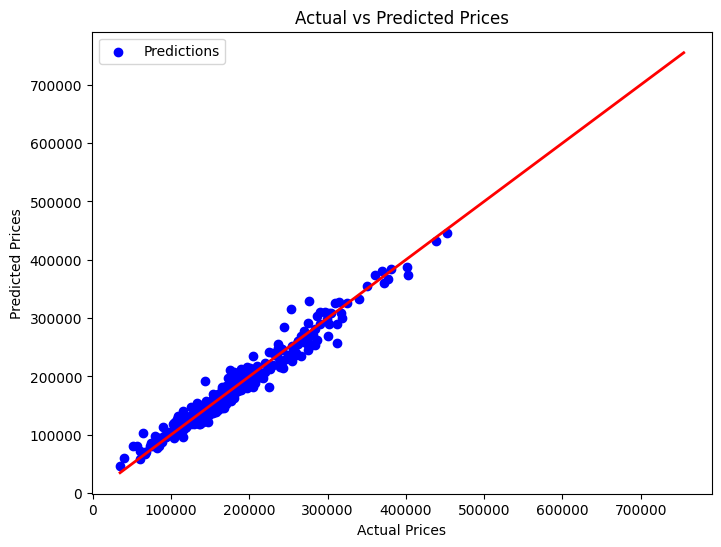

In [18]:
y_pred = final_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

## Plot the Best feature of the best model

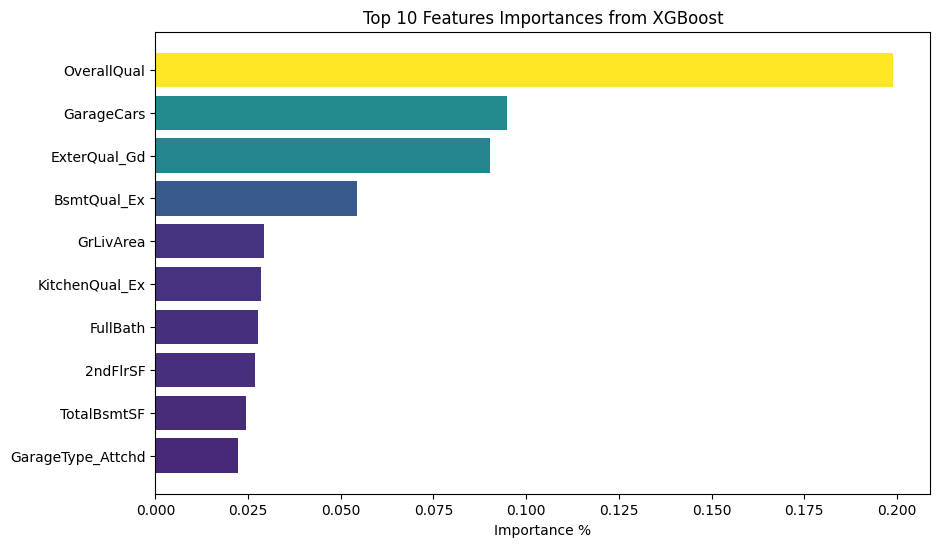

In [19]:
# Extract feature importances
importances = final_model.feature_importances_

# Get feature names, assuming you have a dataframe with the feature names
feature_names = X_final.columns.tolist()

# Create a DataFrame with feature names and their corresponding importance
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Take the top 10 features
top_10_features = feature_importances.head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['feature'], top_10_features['importance'], color=plt.cm.viridis(top_10_features['importance'] / max(top_10_features['importance'])))
plt.xlabel('Importance %')
plt.title('Top 10 Features Importances from XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


The top 10 feature importances for XGBoost are as follows: OverallQual(Rates the overall material and finish of the house) has the highest importance at 0.17,69%. Followed by GarageCars at 9,87%.

## ✅ Model Training & Evaluation

I trained several regression models using **GridSearchCV** to optimize hyperparameters and evaluate them using **Test RMSE** (lower = better). Here are the results:

### 📊 Test RMSE Comparison

| **Model**          | **Test RMSE**  |
|--------------------|----------------|
| LinearRegression   | 88,385.52      |
| Ridge              | 22,707.44      |
| Lasso              | 22,558.10      |
| DecisionTree       | 40,622.70      |
| RandomForest       | 24,466.05      |
| GradientBoosting   | 22,153.94      |
| SVR                | 38,855.15      |
| KNeighbors         | 30,822.74      |
| MLPRegressor       | 23,195.52      |
| **XGBoost**        | **21,924.02 ✅ 🔥** |

---

## ✅ Feature Importances Summary

Across the tree-based models (including **RandomForest**, **GradientBoosting**, and **XGBoost**), **OverallQual** emerged as the most important feature. Other consistently influential features included **GrLivArea**, **GarageCars**, **TotalBsmtSF**, **BsmtQual_Ex**, **2ndFlrSF**, and **TotRmsAbvGrd**.

---

## 🏁 Conclusion

- **Best model overall:** **XGBoost** (lowest RMSE: 21,924).
- **GradientBoosting** and **Lasso** were close behind.
- **Linear Regression** performed poorly without regularization.
- My preprocessing was effective and consistent across all models.
- I explored both classic machine learning algorithms (Linear, Tree, Ensemble) and neural networks (MLPRegressor).



# Result data for Kaggle

In [46]:
# Load the new dataset (same structure as train.csv but without 'Survived')
df_test = pd.read_csv('/content/test.csv')  # Replace with your actual file name

In [47]:
df_test.isnull().sum()[df.isnull().sum() > 0]

,0


## Change all the Na for categorical features for "No ..."

In [48]:
df_test["MiscFeature"] = df_test["MiscFeature"].fillna("No feature")
df_test["Fence"] = df_test["Fence"].fillna("No Fence")
df_test["PoolQC"] = df_test["PoolQC"].fillna("No Pool")
df_test["GarageCond"] = df_test["GarageCond"].fillna("No Garage")
df_test["GarageQual"] = df_test["GarageQual"].fillna("No Garage")
df_test["GarageFinish"] = df_test["GarageFinish"].fillna("No Garage")
df_test["GarageType"] = df_test["GarageType"].fillna("No Garage")
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].fillna("No Basement")
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].fillna("No Basement")
df_test["BsmtCond"] = df_test["BsmtCond"].fillna("No Basement")
df_test["BsmtQual"] = df_test["BsmtQual"].fillna("No Basement")
df_test["FireplaceQu"] = df_test["FireplaceQu"].fillna("No Fireplace")
df_test["MasVnrType"] = df_test["MasVnrType"].fillna("No Veneer")
df_test["Alley"] = df_test["Alley"].fillna("No Alley")
df_test["BsmtExposure"] = df_test["BsmtExposure"].fillna("No Basement")


## What are still missing:

In [49]:
df.isnull().sum()[df.isnull().sum() > 0]

,0


In [50]:
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
df_test = df_test.dropna(subset=['Electrical']) # Only one row is missing
df_test['GarageYrBlt'].fillna(0, inplace=True)
# Create a new column: 1 if garage exists, 0 otherwise
df_test['HasGarage'] = df_test['GarageYrBlt'].apply(lambda x: 0 if x == 0 else 1)

In [51]:
df_test['GarageYrBlt'].fillna(0, inplace=True)
# Create a new column: 1 if garage exists, 0 otherwise
df_test['HasGarage'] = df_test['GarageYrBlt'].apply(lambda x: 0 if x == 0 else 1)

#impute missing values using the median per Neighborhood:
df_test["LotFrontage"] = df_test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)


In [53]:
print(df_test.isnull().sum()[df_test.isnull().sum() > 0])
df_test.duplicated().sum()
# No missing value anymore and no duplicate

MSZoning         4
Utilities        2
Exterior1st      1
Exterior2nd      1
MasVnrArea      15
BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
KitchenQual      1
Functional       2
GarageCars       1
GarageArea       1
SaleType         1
dtype: int64


np.int64(0)

## Preprocessing pipeline

In [78]:
X_test = df_test.drop('Id', axis=1)

X_test_prepro = preprocessor.transform(X_test)

# Create DataFrame with same columns as train
X_final_test = pd.DataFrame(X_test_prepro, columns=all_columns)

# Reset index to match
X_final_test.reset_index(drop=True, inplace=True)

print(X_final_test.head())


   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0   -0.871979     0.436981  0.110671    -0.795596     0.381293  -0.339327   
1   -0.871979     0.481561  0.375668    -0.072372     0.381293  -0.438700   
2    0.073732     0.169503  0.331886    -0.795596    -0.517424   0.853153   
3    0.073732     0.347822 -0.054038    -0.072372     0.381293   0.886277   
4    1.492297    -1.212464 -0.552272     1.374077    -0.517424   0.687530   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0     -1.155705   -0.571009    0.052761    0.603905  ...             0.0   
1     -1.301073    0.026629    1.050677   -0.288760  ...             0.0   
2      0.637169   -0.571009    0.761171   -0.288760  ...             0.0   
3      0.637169   -0.460336    0.346652   -0.288760  ...             0.0   
4      0.346432   -0.571009   -0.396850   -0.288760  ...             0.0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0          

## Create the prediction for the new data

In [80]:
final_model = best_models['XGBoost']  # Because it was the best model

# Make predictions directly
predictions = final_model.predict(X_final_test)

# Export submission file
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': predictions
})
submission.to_csv('/content/submission.csv', index=False)